In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math
import scipy
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error


In [8]:
################################
#   LOADING DATA
#################################
graph = pd.read_csv(r'Graphene_for_BMD_UPDATE.csv')
graph.rename(columns={'variable':'assay'}, inplace=True)

In [9]:
################################
#   PREPARING DATA FOR ANALYSIS
#################################
# Combine the graphene type name and the functionalization in a unique feature called new_name (used in regression)
graph.func.fillna('', inplace=True)
graph.loc[graph.layer ==0.0, 'layer'] = np.nan
# Data set for viability endpoints - df_v
viability_list = ['nucleo', 'alive','cfa', 'viability_alamar', 'ez_cyto', 'viability_pi',
       'viability_ldh', 'viability_mtt',  'viability_cck', 'viability_wst', 'neutral_red', 'viability_hymolisis']
graph = graph.loc[graph['assay'].isin(viability_list), :].copy()
# Remove viability_
graph['assay'] = graph['assay'].apply(lambda row: row.replace('viability_', ''))
# keep only alpha numeric characters in media column  
graph['media'] = graph['media'].apply(lambda row: re.sub(r'\W+', '', row))
df_v = graph.copy() 
df_analysis = df_v[['size_class', 'layer', 'z_pot', 'time', 'cell_type_general',
                'assay', 'Substance', 'func', 'type', 'media', 'bmd_id', 'species' , 'dose', 'value']].copy() 
#Remove nan rows from layer
df_analysis.dropna(subset=['layer'], inplace=True)
df_analysis.reset_index(drop=True, inplace=True)
#Replace with 100 responses higher than 100
df_analysis['value'] = df_analysis['value'].apply(lambda row: 100 if row > 100 else row)
#Remove rows with dose 0
df_analysis = df_analysis[df_analysis['dose']>0]

In [10]:
#Vizualizaing the head of the data set
df_analysis.head()

,size_class,layer,z_pot,time,cell_type_general,assay,Substance,func,type,media,bmd_id,species,dose,value
0,L,2.5,-39.3,24.0,epithelial,nucleo,Graphene oxide,,GO,DMEMF12Glutamax2FBS10001EGF,19,rodent,5.0,94.0
1,L,2.5,-39.3,24.0,epithelial,nucleo,Graphene oxide,,GO,DMEMF12Glutamax2FBS10001EGF,19,rodent,10.0,99.0
2,L,2.5,-39.3,24.0,epithelial,nucleo,Graphene oxide,,GO,DMEMF12Glutamax2FBS10001EGF,19,rodent,25.0,99.0
3,L,2.5,-39.3,24.0,epithelial,nucleo,Graphene oxide,,GO,DMEMF12Glutamax2FBS10001EGF,19,rodent,50.0,100.0
4,L,2.5,-39.3,24.0,epithelial,nucleo,Graphene oxide,,GO,DMEMF12Glutamax2FBS10001EGF,19,rodent,100.0,100.0


In [11]:
df_analysis[['dose']].describe()

,dose
count,483.000000
mean,52.749917
std,72.839659
min,0.005000
25%,10.000000
50%,25.000000
75%,80.000000
max,1000.000000


In [12]:
# How many data points are in the data set?
len(df_analysis)

483

In [13]:
# How many unique experiments are in the data set?
len(df_analysis.bmd_id.unique())

102

In [14]:
# remove assays and medias with less than 4 occurrences
filter_df = pd.DataFrame()
elements = 3
for column in ['assay', 'media']:
    print(df_analysis.groupby(by=column, as_index=False).agg({'bmd_id': pd.Series.nunique}).sort_values(by='bmd_id', ascending=False))    
    a_df = df_analysis.groupby(by=column, as_index=False).agg({'bmd_id': pd.Series.nunique}).sort_values(by='bmd_id', ascending=False)
    columns = a_df[a_df['bmd_id']>elements][column].values
    if len(filter_df)==0:
        filter_df = df_analysis[df_analysis.apply(lambda row: row[column] in columns, axis=1)]
    else:
        filter_df = filter_df[filter_df.apply(lambda row: row[column] in columns, axis=1)]
df_analysis = filter_df.copy()

          assay  bmd_id
6           mtt      41
5           ldh      11
8        nucleo      11
10          wst      10
9            pi       9
1           cck       5
2           cfa       5
3       ez_cyto       5
4     hymolisis       2
7   neutral_red       2
0         alive       1
                          media  bmd_id
9                     RPMI10FBS      34
3                  DMEMF1210FBS      19
7                      F1210FBS      14
1                     DMEM10FBS      10
2                       DMEMF12       8
0                     BEGM10FBS       5
4   DMEMF12Glutamax2FBS10001EGF       3
8                          RPMI       3
5               DMEMF12and10FBS       2
11                     RPMI2FBS       2
6           DMEMORRPMIplus10FBS       1
10                    RPMI10FCS       1


In [15]:
# How many data points remain in the data set?
len(df_analysis)

396

In [16]:
# How many experiments remain in the data set?
len(df_analysis.bmd_id.unique())

86

In [17]:
################################
#   Model Fitting
#################################
#Models
#Model 1: Y[dose] = a * x + b
#Model 2: Y[dose] = a *x**2 + b*x**1 + c
#Model 3: Y[dose] = a * exp {sign * b * dose}\n a*np.exp(b*x)
#Model 4: Y[dose] = a * exp{sign * (b * dose) ^ d}\n
#Model 5: Y[dose] = a * [c - (c - 1) * exp{-b * dose}]\n
#Model 6: Y[dose] = a * [c - (c - 1) * exp{-(b * dose) ^ d}]\n\n
#Model 7: Y[dose] = intercept + v*dose^n/(k^n + dose^n)\n\n\n

In [18]:
#Function to compute the model
def func(model, x, *param):
    if model==1:
        a, b = param
        return a*x + b
    elif model==2:
        a, b, c = param
        return a*x**2 + b*x**1 + c
    elif model==3:
        a, b = param        
        return a*np.exp(b*x)
    elif model==4:
        a, b, d = param
        return a * np.exp(b * x)**d
    elif model==5:
        a, b, c = param
        return a * (c - (c - 1.0) * np.exp(-1.0 * (b * x)))
    elif model==6:
        a, b, c, d = param
        return a * (c - (c - 1.0) * np.exp(-1.0 * np.power(b * x, d)))
    elif model==7:
        intercept, v, k, n = param 
        return intercept + v*x**n/(k**n + x**n)

#Function to fit the curve to the model    
def fitCurve(model, xdata, ydata):
    if model==1:
        return scipy.optimize.curve_fit(lambda x,a,b: a*x + b, xdata, ydata)
    elif model==2:
        return scipy.optimize.curve_fit(lambda x,a,b,c: a*x**2 + b*x**1 + c, xdata, ydata)    
    elif model==3:
        return scipy.optimize.curve_fit(lambda x,a,b: a*np.exp(b*x), xdata, ydata)
    elif model==4:        
        return scipy.optimize.curve_fit(lambda x,a,b,d: a * np.exp(b*x)**d, xdata, ydata)
    elif model==5:        
         return scipy.optimize.curve_fit(lambda x,a,b,c: a * (c - (c - 1.0) * np.exp(-1.0 * (b * x))), xdata, ydata)
    elif model==6:        
        return scipy.optimize.curve_fit(lambda x,a,b,c,d: a * (c - (c - 1.0) * np.exp(-1.0 * np.power(b * x, d))), xdata, ydata)
    elif model==7:        
        return scipy.optimize.curve_fit(lambda x,intercept,v,k,n: intercept + v*x**n/(k**n + x**n), xdata, ydata)

In [19]:
################################
#   Compute the new sampling for dose
#################################
#Parameters for this cell
min_dataPoints = 3 # minimun number of data points
num_values = 10 #Number of samples 
#set min and max value for each experiment
def get_range(row):
    if len(row ['dose'])>=min_dataPoints and max(row ['dose'])>=100 and min(row ['dose'])<50:        
        return pd.Series([min(row ['dose']),max(row ['dose'])])
    else:
        return pd.Series([-10000,10000])

range_analysis = df_analysis[['dose','bmd_id']].groupby(by='bmd_id').apply(lambda row: get_range(row))
range_analysis = range_analysis[range_analysis[0]!=-10000]
maxDownVal = max(range_analysis[0])
minUpVal = min(range_analysis[1])
print("Max Down Value: "+ str(maxDownVal))
print("Min Up Value: " + str(minUpVal))
xdoseValues = np.linspace(maxDownVal, minUpVal, num=num_values)
#Eliminate from the dataset data points which are not inside of maxDownVal and minUpVal
df_analysis = df_analysis[df_analysis['bmd_id'].isin(range_analysis.index)]
df_analysis.reset_index(inplace=True, drop=True)
print('Data Points in the Data Set: ' + str(len(df_analysis)))

Max Down Value: 10.0
Min Up Value: 100.0
Data Points in the Data Set: 310


In [20]:
################################
#   Compute the new sampling for dose
#################################

#Parameters for this cell
plot = False
models = [1,2,3,4]

if plot:
    fig = plt.figure(figsize=(20,800))
    axs = fig.subplots(len(df_analysis.bmd_id.unique())*len(models))
i = 0

mae = {}
summary = pd.DataFrame()
mean_mae = []
value_df = pd.DataFrame()
parameter_df = pd.DataFrame()
model_c = 1
# Compute each model
for model in models:
    mae[model] = []
    print('Processing Model: ' + str(model))
    for id_f in df_analysis.bmd_id.unique():
        print('Processing bmd_id: ' + str(id_f))        
        filter_df = df_analysis[df_analysis['bmd_id']==id_f]
        filter_df.sort_values(by=['dose'], inplace=True)
        filter_df.reset_index(drop=True, inplace=True)        
        xdata = np.array(filter_df['dose'].values)       
        ydata = np.array(filter_df['value'].values) 
        xdata.astype(np.float64)  
        ydata.astype(np.float64)      
        popt, pcov = fitCurve(model, xdata, ydata)              
        ypred = func(model, xdata, *popt)  
        if plot:            
            axs[i].plot(xdata, ypred, 'r-', label= str(id_f))
            axs[i].scatter(xdata, ydata)
            axs[i].title.set_text('Model: '+ str(model) + ' bmd_id: '+str(id_f))
            i = i+1

        meanAbsoluteError = mean_absolute_error(ydata, ypred)            
        mae[model].append(meanAbsoluteError)             

        ##Save the data
        v_df = pd.DataFrame()
        p_df = pd.DataFrame()
        
        v_df['model_' + str(model) +'_values'] = func(model, xdoseValues, *popt)
        v_df['xdose'] = xdoseValues
              
        p_df['model_' + str(model) +'_a'] = [popt[0]]
        p_df['model_' + str(model) +'_b'] = [popt[1]]  
        p_df['model_' + str(model) +'_mae'] = meanAbsoluteError  
        if model==4:                
            p_df['model_' + str(model) +'_d'] = [popt[2]]   
        elif model==5 or model==2:                
            p_df['model_' + str(model) +'_c'] = [popt[2]]
        elif model==6 or model==7:                
            p_df['model_' + str(model) +'_c'] =  [popt[2]]
            p_df['model_' + str(model) +'_d'] =  [popt[3]]                  
        if model_c == 1: #if this is the first model start creating a new dataframe
            for col in filter_df.columns:
                v_df[col] = filter_df.loc[0,col]
                p_df[col] = filter_df.loc[0,col]
            if len(value_df)==0:
                value_df = v_df
            else:
                value_df = pd.concat([value_df,v_df])
            if len(parameter_df)==0:
                parameter_df = p_df
            else:
                parameter_df = pd.concat([parameter_df,p_df])                 
        else:                   
            value_df.loc[value_df['bmd_id']==id_f,v_df.columns] = v_df
            parameter_df.loc[parameter_df['bmd_id']==id_f,p_df.columns] = p_df   
    model_c = model_c + 1
    mean_mae.append(np.mean(mae[model]))
#Compute the mean absolute error
value_df.reset_index(drop=True, inplace=True)
parameter_df.reset_index(drop=True, inplace=True)
summary['model'] = models
summary['mean_mae'] = mean_mae

Processing Model: 1
Processing bmd_id: 3008
Processing bmd_id: 3009
Processing bmd_id: 3010
Processing bmd_id: 3011
Processing bmd_id: 3012
Processing bmd_id: 4070
Processing bmd_id: 4074
Processing bmd_id: 4078
Processing bmd_id: 4082
Processing bmd_id: 4086
Processing bmd_id: 4090
Processing bmd_id: 5115
Processing bmd_id: 5141
Processing bmd_id: 5143
Processing bmd_id: 6054
Processing bmd_id: 6055
Processing bmd_id: 6068
Processing bmd_id: 6069
Processing bmd_id: 6070
Processing bmd_id: 6071
Processing bmd_id: 6072
Processing bmd_id: 6073
Processing bmd_id: 6074
Processing bmd_id: 6075
Processing bmd_id: 6076
Processing bmd_id: 6077
Processing bmd_id: 6078
Processing bmd_id: 6079
Processing bmd_id: 6080
Processing bmd_id: 6081
Processing bmd_id: 6082
Processing bmd_id: 6083
Processing bmd_id: 6084
Processing bmd_id: 6085
Processing bmd_id: 6086
Processing bmd_id: 6087
Processing bmd_id: 6088
Processing bmd_id: 6089
Processing bmd_id: 6090
Processing bmd_id: 6091
Processing bmd_id: 7

In [21]:
summary=summary.sort_values(by='mean_mae')
summary.reset_index(drop=True, inplace=True)
summary

,model,mean_mae
0,2,1.449028e+00
1,1,3.335063e+00
2,4,3.983439e+91
3,3,2.120127e+92


In [22]:
#How many data points remain in the dataset?
len(value_df)

590

In [23]:
#How many unique experiments remain in the dataset
len(value_df.bmd_id.unique())

59

In [24]:
#Select columns accordig to the best model
model = summary.loc[0,'model']

general_columns = ['Substance', 'func', 'size_class', 'layer', 'time', 'cell_type_general', 'species', 'assay', 'type', 'media']

value_column = ['model_' + str(model) +'_values']

parameter_column = ['model_' + str(model) +'_a', 'model_' + str(model) +'_b']              
if model==3:                
    parameter_column.append('model_' + str(model) +'_d')   
elif model==4 or model==2:                
    parameter_column.append('model_' + str(model) +'_c')
elif model==5 or model==6:                
    parameter_column.append('model_' + str(model) +'_c')
    parameter_column.append('model_' + str(model) +'_d')
dose_column = ['xdose']
mae_column = ['model_' + str(model) +'_mae']

valueDS_df = value_df [general_columns + dose_column + value_column+['bmd_id']]
parameterDS_df = parameter_df[general_columns + parameter_column + mae_column+['bmd_id']]
valueDS_df = valueDS_df.rename(columns={dose_column[0]: 'dose'})

In [25]:
## Encoding
col_continuous_value = ['layer', 'time', 'dose'] 
col_continuous_parameter = ['layer', 'time']
col_categorical = ['Substance','func','cell_type_general', 'species','assay', 'media']

def encoding(data_df, value, col_continuous):
    enc_size = {'S':1, 'M':2, 'L':3}   
    dataset_df = pd.get_dummies(data_df[col_categorical], prefix=col_categorical)
    dataset_df['size_class'] = data_df['size_class'].apply(lambda row: enc_size[row])
    dataset_df[col_continuous] = data_df[col_continuous]
    dataset_df[value] = data_df[value]
    return dataset_df

valueDS2_df = encoding(valueDS_df, value_column[0], col_continuous_value)
parameterDS2_df = encoding(parameterDS_df, parameter_column, col_continuous_parameter)
valueDS2_df.head()

,Substance_Graphene,Substance_Graphene oxide,Substance_rGO,func_,func_Amine,func_COOH,func_NH2,func_PEG,func_poly acrylamide,func_poly acrylic acid,...,media_DMEM10FBS,media_DMEMF12,media_DMEMF1210FBS,media_F1210FBS,media_RPMI10FBS,size_class,layer,time,dose,model_2_values
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,3,2.0,24.0,10.0,97.404019
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,3,2.0,24.0,20.0,86.873570
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,3,2.0,24.0,30.0,77.038074
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,3,2.0,24.0,40.0,67.897532
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,3,2.0,24.0,50.0,59.451944


In [26]:
##Normalize the data
def normalize (dataset_df, col_continuous):
    scaler = MinMaxScaler()
    dataset_df[col_continuous+['size_class']] = scaler.fit_transform(dataset_df[col_continuous+['size_class']])
    dataset_df[col_continuous+['size_class']].head()
    return dataset_df

valueDS2_df = normalize(valueDS2_df, col_continuous_value)
parameterDS2_df = normalize(parameterDS2_df, col_continuous_parameter)

In [27]:
# Select dataset to predict response
model_ds = 'value' #parameter
if model_ds=='value':    
    x_columns = [col for col in valueDS2_df.columns if col != value_column[0]]
    y_columns = value_column
    data_df = valueDS2_df
elif model_ds =='parameter': 
    x_columns = [col for col in parameterDS2_df.columns if not(col in parameter_column)]
    y_columns = parameter_column
    data_df = parameterDS2_df

In [28]:
# Create dataset
X =  data_df[x_columns].values
if model_ds=='value':    
    y =  data_df[y_columns].values.ravel()    
elif model_ds =='parameter':
    y =  data_df[y_columns].values

In [29]:
###############################
# MLPRegressor
###############################

In [30]:

# prepare the cross-validation procedure
# LOOCV
cv = LeaveOneOut()
cv2 = RepeatedKFold(n_splits=5, n_repeats=1, random_state=3)
# create model
model = MLPRegressor(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(5, 2), random_state=1, max_iter=10000)
# OLD evaluation model
scores = cross_val_score(model, X, y, scoring='r2', cv=cv2)
print('5Fold crossval R2: %f (%f)' % (np.mean(scores), np.std(scores)))
print(scores)
# NEW EVALUATION OF MODEL
# evaluate model fitting
model.fit(X, y)
fitting = model.score(X, y, sample_weight=None)
print(f'Model fitting R2: {fitting}')
# evaluate model
y_pred = cross_val_predict(model, X, y, cv=cv)
#Calculate r2
r2_score = round(r2(y,y_pred),3)
#Calculate Root Mean Square Error
rms = round(mean_squared_error(y, y_pred, squared=False),2)
# report performance
print(f'LOOCV R2: {r2_score}')
# report performance
print(f'LOOCV RMSE: {rms}')

# Or with Mean Square Error as metric
scoring = "neg_mean_squared_error"
results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
print(); print("Mean Squared Error: ", results.mean()); print("Standard Deviation: ", results.std())

5Fold crossval R2: 0.716094 (0.055490)
[0.73168083 0.78193394 0.63261821 0.76098013 0.67325587]
Model fitting R2: 0.7927842481397743
LOOCV R2: 0.761
LOOCV RMSE: 10.35

Mean Squared Error:  -107.08430500333425
Standard Deviation:  146.44052164621132


In [31]:
###############################
# GradientBoostingRegressor
###############################

In [32]:
# prepare the cross-validation procedure
# NEW LOOCV
cv = LeaveOneOut()
cv2 = RepeatedKFold(n_splits=5, n_repeats=1, random_state=3)
# create model
model = GradientBoostingRegressor(random_state=0)
# OLD evaluation model
scores = cross_val_score(model, X, y, scoring='r2', cv=cv2)
print('5Fold crossval R2: %f (%f)' % (np.mean(scores), np.std(scores)))
print(scores)
# NEW EVALUATION OF MODEL
# evaluate model fitting
model.fit(X, y)
fitting = model.score(X, y, sample_weight=None)
print(f'Model fitting R2: {fitting}')
# evaluate model
y_pred = cross_val_predict(model, X, y, cv=cv)
#Calculate r2
r2_score = round(r2(y,y_pred),3)
#Calculate Root Mean Square Error
rms = round(mean_squared_error(y, y_pred, squared=False),2)
# report performance
print(f'LOOCV R2: {r2_score}')
# report performance
print(f'LOOCV RMSE: {rms}')

# Or with Mean Square Error as metric
scoring = "neg_mean_squared_error"
results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
print(); print("Mean Squared Error: ", results.mean()); print("Standard Deviation: ", results.std())

5Fold crossval R2: 0.717733 (0.026042)
[0.71780985 0.73996445 0.67932076 0.75119768 0.70037306]
Model fitting R2: 0.794023119645169
LOOCV R2: 0.732
LOOCV RMSE: 10.97

Mean Squared Error:  -120.36271837958435
Standard Deviation:  150.12949097663056


In [33]:
###############################
# Feature Importance
###############################

<AxesSubplot: ylabel='index'>

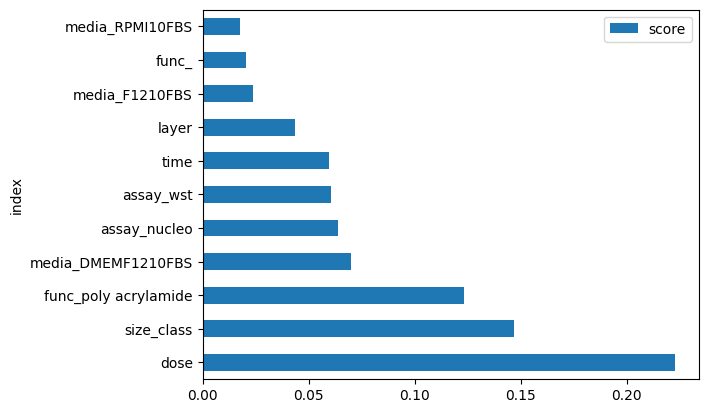

In [34]:
model.fit(X, y)
values = model.feature_importances_

data = pd.DataFrame()
data["score"] = values
data = data.sort_values(by = "score", ascending=False)
data.reset_index(inplace=True)
data['index'] = data['index'].apply(lambda row: data_df.columns[int(row)])
data = data.loc[0:10].set_index('index')
data.plot(kind='barh')

In [35]:
###############################
# Bayesian Ridge Regressor
###############################

In [36]:
# prepare the cross-validation procedure
# NEW LOOCV
cv = LeaveOneOut()
cv2 = RepeatedKFold(n_splits=5, n_repeats=1, random_state=3)
# create model
model = BayesianRidge()
# OLD evaluation model
scores = cross_val_score(model, X, y, scoring='r2', cv=cv2)
print('5Fold crossval R2: %f (%f)' % (np.mean(scores), np.std(scores)))
print(scores)
# NEW EVALUATION OF MODEL
# evaluate model fitting
model.fit(X, y)
fitting = model.score(X, y, sample_weight=None)
print(f'Model fitting R2: {fitting}')
# evaluate model
y_pred = cross_val_predict(model, X, y, cv=cv)
#Calculate r2
r2_score = round(r2(y,y_pred),3)
#Calculate Root Mean Square Error
rms = round(mean_squared_error(y, y_pred, squared=False),2)
# report performance
print(f'LOOCV R2: {r2_score}')
# report performance
print(f'LOOCV RMSE: {rms}')

# Or with Mean Square Error as metric
scoring = "neg_mean_squared_error"
results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
print(); print("Mean Squared Error: ", results.mean()); print("Standard Deviation: ", results.std())

5Fold crossval R2: 0.580322 (0.031264)
[0.5462995  0.63267255 0.55133538 0.57886429 0.5924397 ]
Model fitting R2: 0.612246056366422
LOOCV R2: 0.583
LOOCV RMSE: 13.68

Mean Squared Error:  -187.19605245425308
Standard Deviation:  215.141371822479


In [37]:
###############################
# Random Forest Regressor
###############################

In [38]:
# prepare the cross-validation procedure
cv2 = RepeatedKFold(n_splits=5, n_repeats=1, random_state=3)
cv = LeaveOneOut()
# create model
model = RandomForestRegressor(random_state=1)
# OLD evaluation model
scores = cross_val_score(model, X, y, scoring='r2', cv=cv2)
print('5Fold crossval R2: %f (%f)' % (np.mean(scores), np.std(scores)))
print(scores)
# NEW EVALUATION OF MODEL
# evaluate model fitting
model.fit(X, y)
fitting = model.score(X, y, sample_weight=None)
print(f'Model fitting R2: {fitting}')
# evaluate model
y_pred = cross_val_predict(model, X, y, cv=cv)
#Calculate r2
r2_score = round(r2(y,y_pred),3)
#Calculate Root Mean Square Error
rms = round(mean_squared_error(y, y_pred, squared=False),2)
# report performance
print(f'LOOCV R2: {r2_score}')
# report performance
print(f'LOOCV RMSE: {rms}')

# Or with Mean Square Error as metric
scoring = "neg_mean_squared_error"
results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
print(); print("Mean Squared Error: ", results.mean()); print("Standard Deviation: ", results.std())

5Fold crossval R2: 0.630602 (0.054861)
[0.6885087  0.67123288 0.53997258 0.65664467 0.59665057]
Model fitting R2: 0.8484006603364054
LOOCV R2: 0.596
LOOCV RMSE: 13.47

Mean Squared Error:  -181.45871324713943
Standard Deviation:  297.8261768999517


In [39]:
###############################
# XGBoost
###############################

In [40]:
# prepare the cross-validation procedure
cv2 = RepeatedKFold(n_splits=5, n_repeats=1, random_state=3)
cv = LeaveOneOut()
# create model
model = XGBRegressor()
# evaluate model
# OLD evaluation model
scores = cross_val_score(model, X, y,  cv=cv2)
print('5Fold crossval R2: %f (%f)' % (np.mean(scores), np.std(scores)))
print(scores)
# NEW EVALUATION OF MODEL
# evaluate model fitting
model.fit(X, y)
fitting = model.score(X, y, sample_weight=None)
print(f'Model fitting R2: {fitting}')
# evaluate model
y_pred = cross_val_predict(model, X, y, cv=cv)
#Calculate r2
r2_score = round(r2(y,y_pred),3)
#Calculate Root Mean Square Error
rms = round(mean_squared_error(y, y_pred, squared=False),2)
# report performance
print(f'LOOCV R2: {r2_score}')
# report performance
print(f'LOOCV RMSE: {rms}')

# Or with Mean Square Error as metric
scoring = "neg_mean_squared_error"
results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
print(); print("Mean Squared Error: ", results.mean()); print("Standard Deviation: ", results.std())

5Fold crossval R2: 0.525201 (0.072344)
[0.59521593 0.58310432 0.39435322 0.54651839 0.50681347]
Model fitting R2: 0.8511488387006119
LOOCV R2: 0.477
LOOCV RMSE: 15.32

Mean Squared Error:  -234.68602413529229
Standard Deviation:  402.0035363833858


In [41]:
###############################
# Voting Regressor
###############################

In [42]:
# prepare the cross-validation procedure
# NEW LOOCV
cv = LeaveOneOut()
cv2 = RepeatedKFold(n_splits=5, n_repeats=1, random_state=3)
# create model
reg1 = MLPRegressor(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(5, 2), random_state=1, max_iter=10000)
reg2 = GradientBoostingRegressor(random_state=0)

model = VotingRegressor(estimators=[('mlpr', reg1), ('gbr',reg2)])
# OLD evaluation model
scores = cross_val_score(model, X, y, scoring='r2', cv=cv2)
print('5Fold crossval R2: %f (%f)' % (np.mean(scores), np.std(scores)))
print(scores)
# NEW EVALUATION OF MODEL
# evaluate model fitting
model.fit(X, y)
fitting = model.score(X, y, sample_weight=None)
print(f'Model fitting R2: {fitting}')
# evaluate model
y_pred = cross_val_predict(model, X, y, cv=cv)
#Calculate r2
r2_score = round(r2(y,y_pred),3)
#Calculate Root Mean Square Error
rms = round(mean_squared_error(y, y_pred, squared=False),2)
# report performance
print(f'LOOCV R2: {r2_score}')
# report performance
print(f'LOOCV RMSE: {rms}')

# Or with Mean Square Error as metric
scoring = "neg_mean_squared_error"
results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
print(); print("Mean Squared Error: ", results.mean()); print("Standard Deviation: ", results.std())

5Fold crossval R2: 0.739932 (0.042154)
[0.74880621 0.78254922 0.67233351 0.78182893 0.71414291]
Model fitting R2: 0.8099133489610645
LOOCV R2: 0.769
LOOCV RMSE: 10.17

Mean Squared Error:  -103.43795192166263
Standard Deviation:  136.0038141293695
